In [360]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import math
import datetime 
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy.stats import describe
from pylab import plt, mpl
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
import random

In [362]:
from arch import arch_model

In [363]:
plt.style.use('seaborn')

In [406]:
mydict = {'IGF': 'Global Infrastructure', 
          'IFGL':'International Developed Real Estate ETF',
          'IXN': 'iShares Global Tech ETF',
          'IXJ': 'iShares Global Healthcare ETF',
          'VDE': 'Vanguard Energy ETF',
          'KXI': 'iShares Global Consumer Staples ETF',
#          'IXG': 'iShares Global Financials ETF',
          'SPGP':'iShares Gold Producers UCITS ETF',
          'VIS': 'Vanguard Industrial ETF',
          'RXI': 'iShares Global Consumer Discretionary ETF'
         }

display(list(mydict.values())[:])
#display(list(mydict)[:])
#mydict

['Global Infrastructure',
 'International Developed Real Estate ETF',
 'iShares Global Tech ETF',
 'iShares Global Healthcare ETF',
 'Vanguard Energy ETF',
 'iShares Global Consumer Staples ETF',
 'iShares Gold Producers UCITS ETF',
 'Vanguard Industrial ETF',
 'iShares Global Consumer Discretionary ETF']

In [407]:
# List shares of interest as Yahoo Fiance "Ticker"/"Symbol"

mylist = list(mydict)[:]
#mylist = ['QQQ', 'XLV', 'IFEU', 'IVV', 'VYM', 'VHT', 'IWM', 'VEA', 'VGK', 'IAU', 'GLD']
#mylist = ["danske.co", "MAERSK-B.CO", 'CHR.CO', "NZYM-B.CO", 'LUN.CO', 'GN.CO', 'GEN.CO','CARL-B.CO', 'ORSTED.CO']

noa = len(mylist)



In [408]:
# Create DataFrame to store data
df = pd.DataFrame()
df_change = pd.DataFrame()
rets = pd.DataFrame()

for x in mylist:
    df[x] = pdr.get_data_yahoo(x, start=datetime.datetime(2012, 1, 1), end=datetime.datetime(2019, 8, 1))['Adj Close'] 
    
    df_change['pct_c_{}'.format(x)] = df[x].pct_change()   # 
    rets[x] = np.log(df[x] / df[x].shift(1))*100

rets = rets.dropna()

In [451]:
TABLE = rets.describe()[1:3].round(3).transpose()
TABLE['skewness'] = np.array(rets.skew().round(3))
TABLE['kurtosis'] = np.array(rets.kurt().round(3))
TABLE['ticker'] = np.array(list(mydict)[:])
TABLE = TABLE[['ticker', 'mean', 'std', 'skewness', 'kurtosis']]
TABLE = TABLE.set_index(np.array(list(mydict.values())[:]))
display(TABLE)
# print(TABLE.to_latex(index=True))

,ticker,mean,std,skewness,kurtosis
Global Infrastructure,IGF,0.029,0.782,-0.437,2.683
International Developed Real Estate ETF,IFGL,0.029,0.842,-0.442,4.053
iShares Global Tech ETF,IXN,0.063,1.015,-0.438,2.877
iShares Global Healthcare ETF,IXJ,0.048,0.827,-0.354,2.035
Vanguard Energy ETF,VDE,-0.003,1.288,-0.204,2.025
iShares Global Consumer Staples ETF,KXI,0.034,0.688,-0.436,2.280
iShares Gold Producers UCITS ETF,SPGP,0.059,0.909,-0.345,4.223
Vanguard Industrial ETF,VIS,0.050,0.937,-0.424,2.123
iShares Global Consumer Discretionary ETF,RXI,0.050,0.887,-0.494,2.781


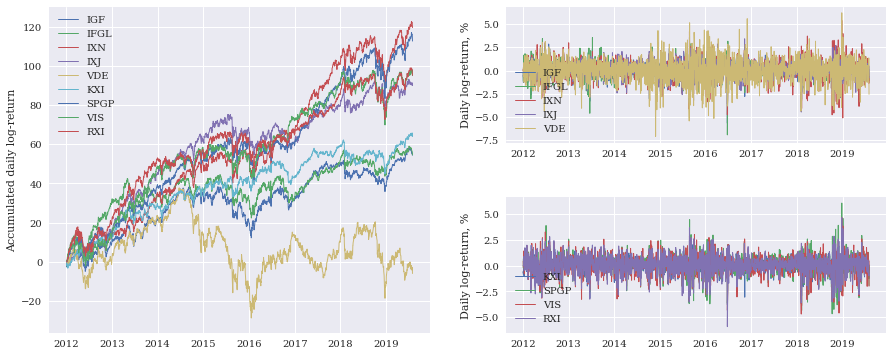

In [410]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)

mpl.rcParams['font.family'] = 'serif'
#%matplotlib inline

plt.subplot(1, 2, 1)
plt.plot(rets.cumsum(), lw=1.0)
plt.ylabel('Accumulated daily log-return')
plt.legend(list(mydict))

plt.subplot(2, 2, 2)
plt.plot(rets.iloc[:, 0:5], lw=1.0)
plt.ylabel('Daily log-return, %')
plt.legend(list(mydict)[0:5])


plt.subplot(2, 2, 4)
plt.plot(rets.iloc[:, 5:], lw=1.0)
plt.ylabel('Daily log-return, %')
plt.legend(list(mydict)[5:])

plt.show()

In [411]:
# Random assigned weight
weights = np.random.random(noa)
weights /= np.sum(weights) 
weights

array([0.01227152, 0.0572412 , 0.25549022, 0.0100919 , 0.16463875,
       0.16989226, 0.10075706, 0.12027764, 0.10933945])

In [412]:
# Expected portfolio return (annualized)
EPR = np.sum(rets.mean() * weights) * 252

# Portfolio Variance annualized
PV = np.dot(weights.T, np.dot(rets.cov() * 252, weights))

# Portfolio Volatility (Standard deviation)
P_std = math.sqrt(PV)

print('Annualized:')
print('Expected portfolio return =',EPR.round(2))
print('Portfolio Variance =', PV.round(2))
print('Portfolio Volatility (Standard deviation)', np.round(P_std,2))
print('')
print('Annnualized Expected return:')
display(rets.mean()*252)
print('Annualized Covariance matrix')
display(np.round((rets/100).cov()*252*100, 2))
display(rets.corr().round(2))

Annualized:
Expected portfolio return = 10.37
Portfolio Variance = 170.32
Portfolio Volatility (Standard deviation) 13.05

Annnualized Expected return:


IGF      7.213270
IFGL     7.220257
IXN     15.833883
IXJ     11.979537
VDE     -0.804477
KXI      8.476363
SPGP    14.920301
VIS     12.583744
RXI     12.608013
dtype: float64

Annualized Covariance matrix


,IGF,IFGL,IXN,IXJ,VDE,KXI,SPGP,VIS,RXI
IGF,1.54,1.31,1.35,1.13,1.69,1.07,1.10,1.28,1.31
IFGL,1.31,1.79,1.43,1.15,1.50,1.05,1.14,1.30,1.41
IXN,1.35,1.43,2.60,1.56,1.93,1.18,1.98,1.91,1.92
IXJ,1.13,1.15,1.56,1.72,1.45,1.05,1.44,1.43,1.43
VDE,1.69,1.50,1.93,1.45,4.18,1.14,1.67,2.08,1.82
KXI,1.07,1.05,1.18,1.05,1.14,1.19,1.01,1.10,1.15
SPGP,1.10,1.14,1.98,1.44,1.67,1.01,2.08,1.65,1.65
VIS,1.28,1.30,1.91,1.43,2.08,1.10,1.65,2.21,1.77
RXI,1.31,1.41,1.92,1.43,1.82,1.15,1.65,1.77,1.98


,IGF,IFGL,IXN,IXJ,VDE,KXI,SPGP,VIS,RXI
IGF,1.00,0.79,0.68,0.69,0.66,0.79,0.61,0.69,0.75
IFGL,0.79,1.00,0.66,0.66,0.55,0.72,0.59,0.65,0.75
IXN,0.68,0.66,1.00,0.74,0.59,0.67,0.85,0.80,0.85
IXJ,0.69,0.66,0.74,1.00,0.54,0.73,0.76,0.73,0.77
VDE,0.66,0.55,0.59,0.54,1.00,0.51,0.57,0.69,0.63
KXI,0.79,0.72,0.67,0.73,0.51,1.00,0.64,0.68,0.75
SPGP,0.61,0.59,0.85,0.76,0.57,0.64,1.00,0.77,0.81
VIS,0.69,0.65,0.80,0.73,0.69,0.68,0.77,1.00,0.85
RXI,0.75,0.75,0.85,0.77,0.63,0.75,0.81,0.85,1.00


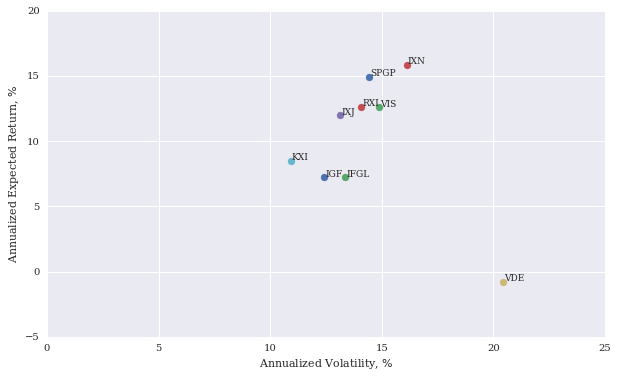

In [452]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
for i,type in enumerate(mylist):
    x2 = np.sqrt((rets[type]).var()*252)
    y2 = rets[type].mean()*252
    
    plt.scatter(x2, y2, marker='o')  
    plt.text(x2+0.05, y2+0.05, type, fontsize=9)
    
    axes = plt.gca()
    axes.set_xlim([0,25])
    axes.set_ylim([-5,20])

    plt.xlabel('Annualized Volatility, $\%$')
    plt.ylabel('Annualized Expected Return, $\%$')

plt.show()

In [414]:
# Monte Carlo simulation

def port_ret(weights):
    return np.sum(rets.mean() * weights) *252

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    
p_rets = []
p_vols = []
    
for p in range (50000):
    weights = np.random.random(noa)
    weights /= np.sum(weights) 
    p_rets.append(port_ret(weights))
    p_vols.append(port_vol(weights))
    
p_rets = np.array(p_rets)
p_vols = np.array(p_vols)

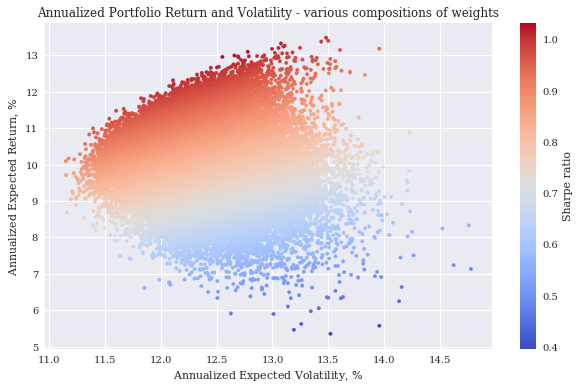

In [415]:
plt.figure(figsize=(10,6))
plt.scatter(p_vols, p_rets, c=p_rets / p_vols, marker = '.', cmap='coolwarm')
plt.xlabel('Annualized Expected Volatility, $\%$')
plt.ylabel('Annualized Expected Return, $\%$')
plt.title('Annualized Portfolio Return and Volatility - various compositions of weights')
plt.colorbar(label='Sharpe ratio')

In [416]:
# Definition of Sharpe Ratio  (Equal weights)

# The Sharpe Ratio (negative) to be minimized
def sharpe_ratio(weights):
    return -port_ret(weights) / port_vol(weights)

# Equality constraint
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for parameters
bnds = tuple((0,1) for x in range(noa))

# Equal weights 
eweights = np.array(noa * [1. / noa,])

print('Equal weight sharp ratio = ', -sharpe_ratio(eweights).round(4))

Equal weight sharp ratio =  0.8138


In [417]:
# Max Sharpe Ratio i.e. return 
#%%time
opts = sco.minimize(sharpe_ratio, eweights, method='SLSQP', bounds=bnds, constraints=cons)
#print(opts)
print('optimal portfolio weights = ', opts['x'].round(3))
print('Annualized portfolio return = ', port_ret(opts['x']).round(3))
print('Annualized portfolio vol = ', port_vol(opts['x']).round(3))
print('Maximum Sharpe Ratio = ',(port_ret(opts['x'])/port_vol(opts['x'])).round(4),'=',-sharpe_ratio(opts.x).round(4))

optimal portfolio weights =  [0.    0.    0.216 0.209 0.    0.048 0.527 0.    0.   ]
Annualized portfolio return =  14.194
Annualized portfolio vol =  13.357
Maximum Sharpe Ratio =  1.0626 = 1.0626


In [418]:
# Minimize Vol
optv = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
print('weights = ', optv['x'].round(3))
print('Minimum  Annualized vol = ', port_vol(optv['x']).round(3))
print('Annualized return = ', port_ret(optv['x']).round(3))
print('Sharpe ratio = ', (port_ret(optv['x']) / port_vol(optv['x'])).round(3), '=', -sharpe_ratio(optv['x']))

weights =  [0.108 0.073 0.    0.073 0.    0.669 0.077 0.    0.   ]
Minimum  Annualized vol =  10.696
Annualized return =  8.998
Sharpe ratio =  0.841 = 0.8412216104597211


In [419]:
# Effecient Frontier pp. 224

# Binding Constraint for efficient frontier
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds
bnds = tuple((0,1) for x in weights)

# Target Return
trets = np.linspace(5, 15, 50) # We want to find minimum vol portfolios to each target return (trets).

tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])      # Store the minimum volatilities corresponding to the target return.

# Store tvols as numpy array
tvols = np.array(tvols)


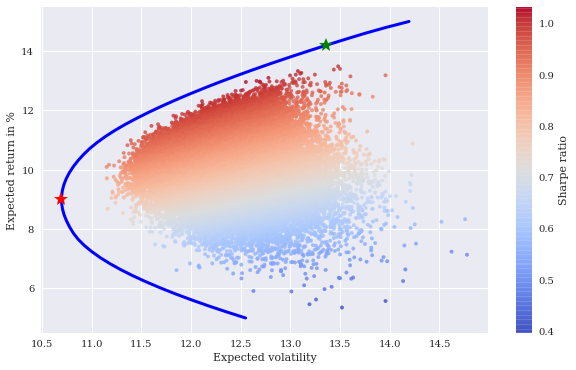

In [420]:
plt.figure(figsize=(10,6))
plt.scatter(p_vols, p_rets, c=p_rets / p_vols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=3.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'g*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return in %')
plt.colorbar(label='Sharpe ratio')

In [421]:
# Capital Market Line pp. 425

# Index position of minimum vol portfolio
ind = np.argmin(tvols)                      # Find minimum variance portfolio - the # in list
evols = tvols[ind:]                         # Relevant portfolio vol from min vol and onwards from min vol and on...
erets = trets[ind:]                         # Relevant portfolio ret


tck = sci.splrep(evols, erets)              # Cubic splines interpolation on these values


def f(x):
    '''Effecient frontier function (splines approximation).'''
    return sci.splev(x, tck, der=0)

def df(x):
    '''First derivative of Efficient frontier fct.'''
    return sci.splev(x, tck, der=1)

In [423]:
# page 427
rf=1.0
def equations(p, rf=1.0):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.05, 0.51])

print('Optimal parameter values = ', opt.round(4))

print('Check that eq holds:', np.round(equations(opt), 10))


Optimal parameter values =  [ 1.      0.9891 13.7392]
Check that eq holds: [ 0.0e+00  1.5e-09 -0.0e+00]


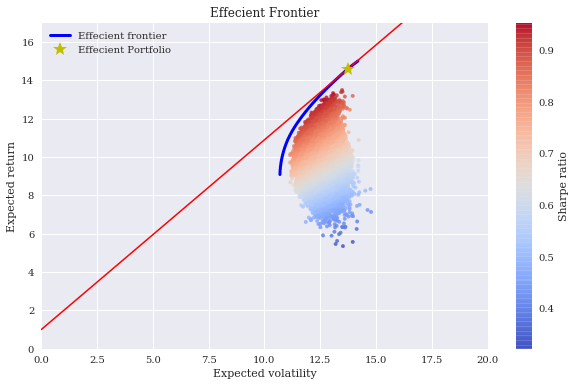

In [424]:
#plt.figure(figsize=(10,6))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

plt.scatter(p_vols, p_rets, c=(p_rets-rf) / p_vols,                      # Check rf = 0.01
            marker='.', alpha=0.8, cmap='coolwarm')

plt.plot(evols, erets, 'b', lw=3.0, label='Effecient frontier')

cx = np.linspace(0.0, 18.0)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)

plt.plot(opt[2], f(opt[2]), 'y*', markersize=15, label='Effecient Portfolio')

plt.grid(True)

#plt.axhline(0,color='k', ls='--', lw=2.0)
#plt.axvline(0,color='k', ls='--', lw=2.0)

axes = plt.gca()
axes.set_xlim([0,20])
axes.set_ylim([0,17])

plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.title('Effecient Frontier')
plt.colorbar(label='Sharpe ratio')
plt.legend()

In [425]:


cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - f(opt[2])},
        {'type': 'eq', 'fun': lambda x: np.sum(x)-1})

res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)


print('Effecient Portfolio Weights = ', res.x.round(3))
print('Annualized effecient P vol = ', np.round(res.fun,3) , '=' , opt[2].round(3), '=', port_vol(res['x']).round(3))
print('Annualized effecient P return = ', f(opt[2]).round(3), '=',port_ret(res['x']).round(3))

Effecient Portfolio Weights =  [0.    0.    0.257 0.192 0.    0.    0.551 0.    0.   ]
Annualized effecient P vol =  13.739 = 13.739 = 13.739
Annualized effecient P return =  14.589 = 14.589


## Moving on to GARCH modelleing

In [426]:
#rets.describe()
#rets['QQQ'][:-n_time]

In [427]:
n_time = 100
n_test = 10
H = -n_time+n_test


parameters = np.zeros((noa,4))
forecasts = np.zeros((noa,n_test))
forecast_variance = np.zeros(noa)
std_resid = np.zeros((noa,len(rets['IGF'][:-n_time])))



for i,n in enumerate(mylist):
    # split into train/test = in-sample/out-of-sample
    train, test = rets[n][:-n_time], rets[n][-n_time : H] 
    #train, test = rets['IVV'][1:-n_test], rets['IVV'][-n_test:]

    # define GARCH model
    model = arch_model(train, mean='Constant', vol='GARCH', p=1, q=1)
    # model = arch_model(train, p=1, o=1, q=1) # GJR Garch - just change parameters to 5 instead of 4

    # fit model
    res = model.fit(disp='off')

    # Save parameter estimates
    parameters[i][:] = res.params[:]
    
    # Save standardized residuals
    std_resid[i][:] = res.resid / res.conditional_volatility
    
    # forecast variance
    forecasts[i][:] = res.forecast(horizon=n_test).variance.dropna().values.T[:,0]
    forecast_variance[i] = forecasts[i].mean() # Each asset's forecasted variance for period n_test period ahead

In [428]:
# All mu (expected return)
F_mu = parameters[:, 0]

# Forecasted variances
F_var = forecast_variance

In [429]:
parameters

array([[0.03804557, 0.04818697, 0.16284188, 0.76716117],
       [0.04065522, 0.02362763, 0.12238014, 0.85058175],
       [0.0924911 , 0.05093657, 0.11071914, 0.83828513],
       [0.07206526, 0.02873141, 0.1112022 , 0.84959581],
       [0.02452073, 0.02693155, 0.07263755, 0.91241137],
       [0.04311938, 0.04508821, 0.15757532, 0.75510037],
       [0.08789809, 0.03107289, 0.10373839, 0.85689194],
       [0.06570754, 0.06916743, 0.12359461, 0.79886974],
       [0.06954737, 0.03391277, 0.13816218, 0.82585834]])

In [433]:
# forecast the test set
forecasts = res.forecast(horizon=n_test)
F_V = forecasts.variance.dropna().values.T
#F_V

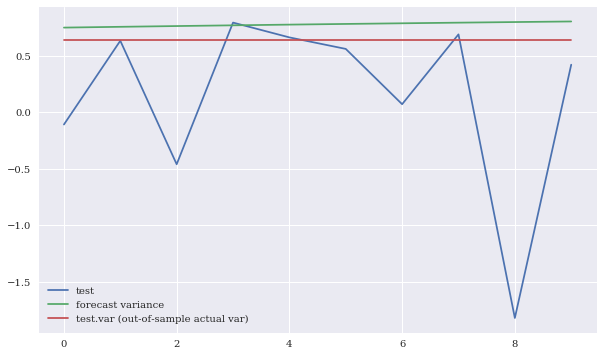

In [434]:
plt.figure(figsize=(10,6))

# plot the actual variance
var = test
plt.plot(var.values, label='test')

# plot forecast variance
plt.plot(F_V, label='forecast variance')

# plot actual out-of-sample variance
plt.plot(np.full((1,n_test), test.var()).T, label='test.var (out-of-sample actual var)')

#plt.plot(test**2, label='squared return')

plt.legend()
plt.show()

In [435]:
print(train.var())
print(train[-500:].var())
print(test.var())


0.7999110890459704
0.7738311570422629
0.6420060334087309


In [436]:
print(F_V.mean())

0.7778654620978862


In [437]:
squared_rets = rets ** 2

In [438]:
#plot_acf(squared_rets['IVV'][-100:])
#pyplot.show()

## Simulation

\begin{align}
    r_{t+1} &= \mu + \sigma_{t+1} z_{t+1} \\
    \sigma^2_{t+1} &= \omega + \alpha r_t^2 + \beta \sigma_t^2  \\
    z &\sim \textit{i.i.d. } \mathcal{N}(0,1)
\end{align}

In [439]:
import math
import numpy as np
import numpy.random as npr
from pylab import plt, mpl

In [440]:
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [441]:
#parameters.round(4)
parameters[0]

# Maybe don't need forecasts as we do FHS self...
# forecasts.round(2)
# forecasts[0].mean()
# forecast_vol.round(3)

array([0.03804557, 0.04818697, 0.16284188, 0.76716117])

In [442]:
# Filtered Historical Simulation

#npr.seed(741)
N = n_test # 10

# Create dictionaries
SIM_RET = {}
SIM_SIGMA = {}
ACC_RET = {}
AVG_VOL = {}

# Loop over assets
for j,x in enumerate(mylist):  #range(noa):

    # Define parameters for the given asset
    param = parameters[j]
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    beta = param[3]
    acc_ret = []                                                   # space for accumulated returns
    avg_vol = []
    
    # Loop for simulations
    for i in range(5000):
        z = random.sample(list(std_resid[j][:-n_test]), 10)            # Bootstrap random draw from std.res.
        sim_ret = np.empty(N)                                          # Define empty vector for simulated return
        
        
        # Define vector for simulated sigma_(t+1) for GARCH(1,1)
        sim_sigma = np.empty(N)
        sim_sigma[0] = ((train[-1] - mu)/ std_resid[j][-n_test])       # sigma_t+1 is predetermined
        
        # Loop for horizon
        for n in range(N-1):
            sim_ret[n] = mu + sim_sigma[n] * z[n]
            sim_sigma[n+1] =  math.sqrt(omega + alpha * sim_ret[n]**2 + beta * sim_sigma[n]**2)
        
        acc_ret.append(np.sum(sim_ret))                               # all 50.000 accumulated return
        avg_vol.append(sum(sim_sigma)/len(sim_sigma))                 # all 50.000 average sigma 

    ACC_RET["asset_{0}".format(x)] = acc_ret
    AVG_VOL["asset_{0}".format(x)] = avg_vol

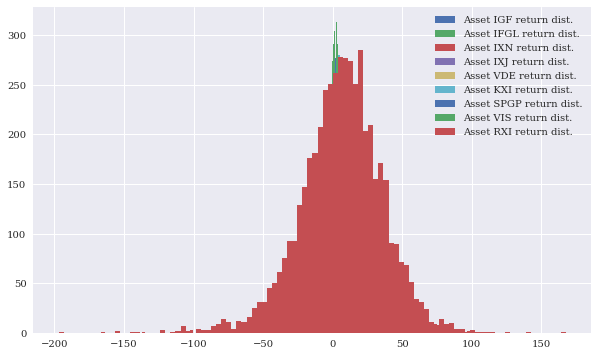

In [443]:
plt.figure(figsize=(10,6))
for i in mylist:
    plt.hist(ACC_RET['asset_%s' %i], bins=100, label='Asset %s return dist.' %i)
plt.legend()
plt.show()

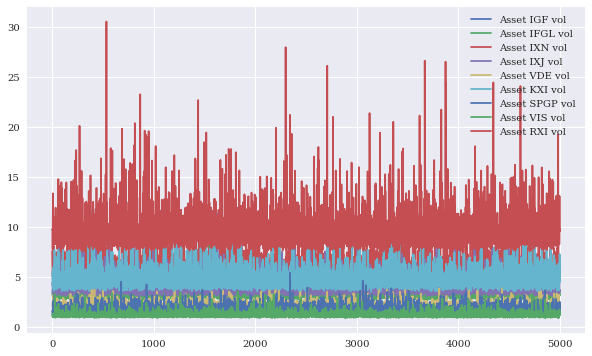

In [444]:
plt.figure(figsize=(10,6))
for i in mylist:
    plt.plot(AVG_VOL['asset_%s' %i], label='Asset %s vol' %i)
plt.legend()
plt.show()

In [445]:
for i in mylist:
    print('Average sim vol asset %s = ' %i, np.mean(AVG_VOL['asset_%s' %i]).round(4))

for i in mylist:
    print('Average sim acc. return asset %s = ' %i, np.mean(ACC_RET['asset_%s' %i]).round(4))

Average sim vol asset IGF =  1.4897
Average sim vol asset IFGL =  3.419
Average sim vol asset IXN =  5.9215
Average sim vol asset IXJ =  4.1012
Average sim vol asset VDE =  2.2296
Average sim vol asset KXI =  4.8397
Average sim vol asset SPGP =  1.8314
Average sim vol asset VIS =  1.2526
Average sim vol asset RXI =  9.7689
Average sim acc. return asset IGF =  1.2908
Average sim acc. return asset IFGL =  2.7504
Average sim acc. return asset IXN =  5.2555
Average sim acc. return asset IXJ =  4.3023
Average sim acc. return asset VDE =  2.3038
Average sim acc. return asset KXI =  3.0956
Average sim acc. return asset SPGP =  2.2001
Average sim acc. return asset VIS =  1.6295
Average sim acc. return asset RXI =  6.3496


Now We have obtained estimates for the 10-period expected return and variance for each asset.

Assuming constant correlation between the assets, we have obtained a new covariance matrix. And expected return, so we can construct a new effecient portfolio. 

In [446]:
# Create DataFrame from dictionary of accumulated return:

df_sim_ret = pd.DataFrame.from_dict(ACC_RET)
df_sim_ret.describe().round(3)

,asset_IGF,asset_IFGL,asset_IXN,asset_IXJ,asset_VDE,asset_KXI,asset_SPGP,asset_VIS,asset_RXI
count,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000
mean,1.291,2.750,5.256,4.302,2.304,3.096,2.200,1.629,6.350
std,4.711,10.507,24.055,15.993,8.584,15.567,7.391,4.998,30.005
min,-27.161,-54.442,-166.633,-90.232,-36.232,-93.943,-38.622,-33.991,-196.874
25%,-1.354,-3.658,-8.466,-5.423,-2.983,-5.691,-2.056,-1.308,-10.789
50%,1.456,3.063,6.083,4.600,2.460,3.584,2.445,1.723,7.536
75%,4.149,9.354,19.823,14.481,7.684,12.316,6.655,4.668,24.957
max,23.609,53.534,99.063,67.576,39.228,76.867,48.929,31.025,167.931


In [447]:
# Create DataFrame from dictionary of average volatilty:

df_sim_vol = pd.DataFrame.from_dict(AVG_VOL)
df_sim_vol.describe().round(3)

,asset_IGF,asset_IFGL,asset_IXN,asset_IXJ,asset_VDE,asset_KXI,asset_SPGP,asset_VIS,asset_RXI
count,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000
mean,1.490,3.419,5.921,4.101,2.230,4.840,1.831,1.253,9.769
std,0.281,0.548,1.164,0.750,0.287,0.986,0.346,0.264,1.850
min,1.114,2.691,4.436,3.061,1.847,3.552,1.399,0.927,7.573
25%,1.299,3.062,5.115,3.599,2.039,4.174,1.597,1.082,8.619
50%,1.416,3.285,5.641,3.912,2.162,4.589,1.740,1.188,9.275
75%,1.596,3.617,6.369,4.403,2.338,5.215,1.955,1.342,10.349
max,4.101,10.396,23.307,11.361,5.637,12.307,5.443,3.596,30.597


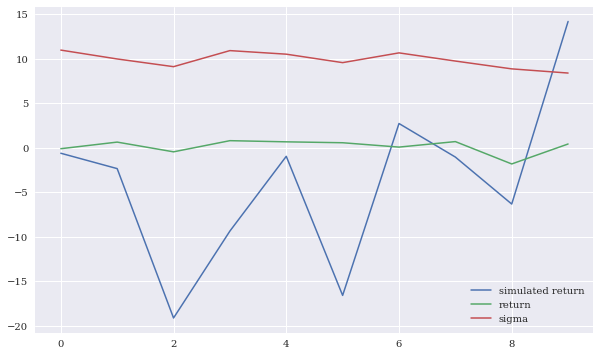

In [448]:
plt.figure(figsize=(10,6))
plt.plot(sim_ret, lw=1.5, label='simulated return')
plt.plot(var.values, lw=1.5, label='return')
plt.plot(sim_sigma, lw=1.5, label='sigma')
plt.legend()
plt.show()